In [1]:
import MatchAndPlot
import multiprocessing as mp
import multiprocessing
import os
import glob
import time
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt

In [2]:
def trace(m, z, a0=1.5, a1=0.3, a2=2.5, m0=0.5, m1=0.36):
    r = np.log10(1 + z)
    M = np.log10(m/1e9)
    p = M-m1-a2*r
    p[p<0] = 0
    return M - m0 + a0*r - a1*p**2

In [3]:
def uvj_constants(z):
    if (z>2.0 and z<3.5):
        redshift='2.0<z<3.5'
        x1 = 1.4
        y1 = 1.3
        const = 0.59
    elif (z>1.5 and z<2.0):
        redshift='1.5<z<2.0'
        x1 = 1.5
        y1 = 1.3
        const = 0.59
    elif (z>0 and z<1.5):
        x1 = 1.6
        y1 = 1.3
        if z<0.5:
            redshift='0<z<0.5'
            const = 0.69
        elif z>0.5:
            redshift='0.5<z<1.5'
            const = 0.59
    x_right = (y1 - const) / 0.88  # right point of horizontal line
    x_horizontal = np.linspace(0, x_right, 50)  # horizontal line
    y_horizontal = np.ones(x_horizontal.size)*y1     # horizontal line
    x_diagonal = np.linspace(x_right, x1, 50)   # diagonal line
    y_diagonal = 0.88*x_diagonal + const       # diagonal line
    y_lower = y_diagonal[-1]    # lower point of vertical line
    y_vertical = np.linspace(y_lower, 4, 50)  # vertical line
    x_vertical = np.ones(y_vertical.size)*x1      # vertical line
    return redshift, x_diagonal, y_diagonal, x_horizontal, y_horizontal, x_vertical, y_vertical


Done in 10.4867 seconds


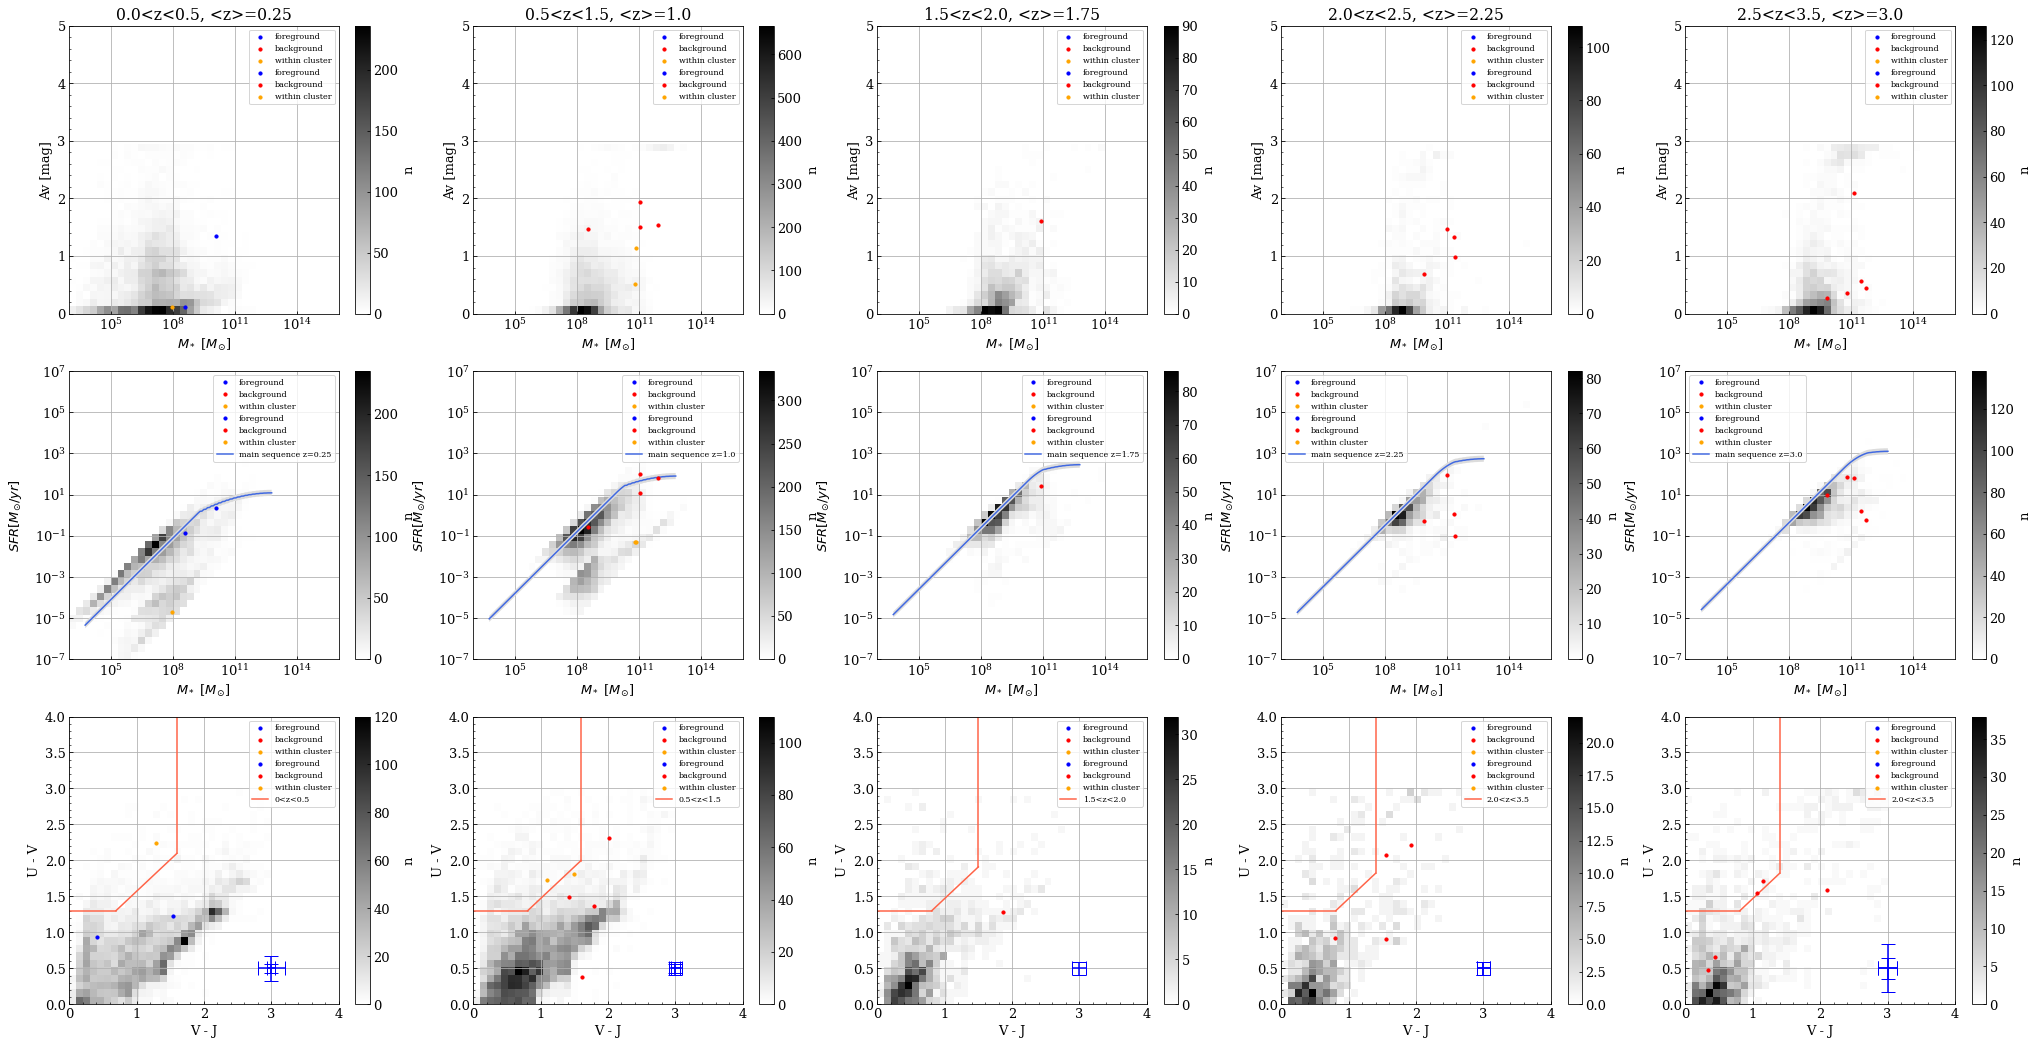

In [4]:
import warnings
from functools import partial
from multiprocessing import Process, Value, Array
'''
class NoDaemonProcess(mp.Process):
    # make 'daemon' attribute always return False
    def _get_daemon(self):
        return False
    def _set_daemon(self, value):
        pass
    daemon = property(_get_daemon, _set_daemon)

class NonDaemonPool(multiprocessing.pool.Pool):
    def Process(self, *args, **kwds):
        proc = super(NonDaemonPool, self).Process(*args, **kwds)

        class NonDaemonProcess(proc.__class__):
            """Monkey-patch process to ensure it is never daemonized"""
            @property
            def daemon(self):
                return False

            @daemon.setter
            def daemon(self, val):
                pass

        proc.__class__ = NonDaemonProcess
        return proc
'''

path2='/home/yjm/miniconda/Outputs'
files_list = glob.glob('*')
if __name__ == '__main__':
    tic = time.time()
    
    warnings.filterwarnings("ignore")
    mass2 = np.logspace(4, 13, 100)
    index=5
    mass_sorted = mass2
    mass=[]
    mass_16=[]
    mass_84=[]
    z=[]
    Av=[]
    Av_16=[]
    Av_84=[]
    sfr=[]
    sfr_16=[]
    MASS_err_individual=[]
    AV_err_individual=[]
    SFR_err_individual=[]
    sfr_84=[]
    UV_err=[]
    VJ_err=[]
    MASS_err=[]
    AV_err=[]
    SFR_err=[]
    UV=[]
    VJ=[]
    flag=False
    os.chdir(path2)
    files_list = glob.glob('*')
    fig2,axes=plt.subplot_mosaic([['1','2', '3','4', 'a'], ['5', '6', '7', '8', 'b'], ['9','10','11','12', 'c']], empty_sentinel="X", figsize=(35, 18))
    axes2 = list(axes.values())
    color='tomato'
    z_bins = np.array([[0., 0.5, 0.25],[0.5, 1.5, 1.0],[1.5, 2.0, 1.75], [2.0, 2.5, 2.25], [2.5, 3.5, 3.]])

    #pool = NonDaemonPool(3) 
    pool = mp.Pool(3)
    p = pool.map(MatchAndPlot.main_body, files_list)

    num_bins = 40
    for a in p:
        if type(a) is tuple:
            (mass_, mass_16_, mass_84_, z_, Av_, av_16, av_84, sfr_, sfr_16_, sfr_84_, z_alma, UV_, VJ_, uv_err, vj_err, id_detected_, idxx_, z_16, z_84, cluster_redshift) = a
            mass = np.append(mass, mass_)
            mass_16 = np.append(mass_16, mass_16_)
            mass_84 = np.append(mass_84, mass_84_)
            z = np.append(z, z_)
            Av = np.append(Av, Av_)
            Av_16 = np.append(Av_16, av_16)
            Av_84 = np.append(Av_84, av_84)
            sfr = np.append(sfr, sfr_)
            sfr_16 = np.append(sfr_16, sfr_16_)
            sfr_84 = np.append(sfr_84, sfr_84_)
            UV = np.append(UV, UV_)
            VJ = np.append(VJ, VJ_)
            UV_err = np.append(UV_err, uv_err)
            VJ_err = np.append(VJ_err, vj_err)
            for i in range(index):
                coor_z = np.where((z_>z_bins[i,0]) & (z_<z_bins[i,1]))
                coor_z_alma_ = np.where((z_alma>z_bins[i,0]) & (z_alma<z_bins[i,1]))
                coor_z_idxx_ = reduce(np.intersect1d,(coor_z, idxx_))
                coor_before2_ = np.where(z_84[coor_z_idxx_] < (cluster_redshift - 0.1))
                coor_behind2_ = np.where(z_16[coor_z_idxx_] > (cluster_redshift + 0.1))
                coor_within2_ = np.where((z_16[coor_z_idxx_] < (cluster_redshift + 0.1)) & (z_84[coor_z_idxx_] > (cluster_redshift - 0.1)))
                if flag is not True:
                    axes2[i].scatter(mass_[coor_z_idxx_][coor_before2_], Av_[coor_z_idxx_][coor_before2_], s=10, label='foreground', zorder=15, c='blue')
                    axes2[i].scatter(mass_[coor_z_idxx_][coor_behind2_], Av_[coor_z_idxx_][coor_behind2_], s=10, label='background', zorder=15, c='red')
                    axes2[i].scatter(mass_[coor_z_idxx_][coor_within2_], Av_[coor_z_idxx_][coor_within2_], s=10, label='within cluster', zorder=15, c='orange')
                    mass_err_x = np.vstack((mass_[coor_z_idxx_]-mass_16_[coor_z_idxx_], mass_84_[coor_z_idxx_]-mass_[coor_z_idxx_]))
                    av_err_x = np.vstack((Av_[coor_z_idxx_]-av_16[coor_z_idxx_], av_84[coor_z_idxx_]-Av_[coor_z_idxx_]))
                    #axes2[i].errorbar(0.8, 0.2, xerr=mass_err_mean, yerr=Av_err_mean, c='blue', zorder=2, capsize=7, transform=axes2[i].transAxes)
                    
                    axes2[i+index].scatter(mass_[coor_z_idxx_][coor_before2_], sfr_[coor_z_idxx_][coor_before2_], s=10, label='foreground', zorder=15, c='blue')
                    axes2[i+index].scatter(mass_[coor_z_idxx_][coor_behind2_], sfr_[coor_z_idxx_][coor_behind2_], s=10, label='background', zorder=15, c='red')
                    axes2[i+index].scatter(mass_[coor_z_idxx_][coor_within2_], sfr_[coor_z_idxx_][coor_within2_], s=10, label='within cluster', zorder=15, c='orange')
                    sfr_err_x = np.vstack(([sfr_[coor_z_idxx_]-sfr_16_[coor_z_idxx_], sfr_84_[coor_z_idxx_]-sfr_[coor_z_idxx_]]))
                    #axes2[i+index].errorbar(0.8, 0.2, xerr=mass_err_mean, yerr=sfr_err_mean, c='blue', zorder=2, capsize=7, transform=axes2[i+index].transAxes)
                    
                    axes2[i+index*2].scatter(VJ_[coor_z_idxx_][coor_before2_], UV_[coor_z_idxx_][coor_before2_], s=10, label='foreground', zorder=15, c='blue')
                    axes2[i+index*2].scatter(VJ_[coor_z_idxx_][coor_behind2_], UV_[coor_z_idxx_][coor_behind2_], s=10, label='background', zorder=15, c='red')
                    axes2[i+index*2].scatter(VJ_[coor_z_idxx_][coor_within2_], UV_[coor_z_idxx_][coor_within2_], s=10, label='within cluster', zorder=15, c='orange')
                    uv_err_mean = np.mean(uv_err[coor_z_idxx_])
                    vj_err_mean = np.mean(vj_err[coor_z_idxx_])
                    axes2[i+index*2].errorbar(3, 0.5, xerr=uv_err_mean, yerr=vj_err_mean, c='blue', zorder=2, capsize=7)
                else:
                    axes2[i].scatter(mass_[coor_z_idxx_][coor_before2_], Av_[coor_z_idxx_][coor_before2_], s=10, zorder=15, c='blue')
                    axes2[i].scatter(mass_[coor_z_idxx_][coor_behind2_], Av_[coor_z_idxx_][coor_behind2_], s=10, zorder=15, c='red')
                    axes2[i].scatter(mass_[coor_z_idxx_][coor_within2_], Av_[coor_z_idxx_][coor_within2_], s=10, zorder=15, c='orange')
                    
                    axes2[i+index].scatter(mass_[coor_z_idxx_][coor_before2_], sfr_[coor_z_idxx_][coor_before2_], s=10, zorder=15, c='blue')
                    axes2[i+index].scatter(mass_[coor_z_idxx_][coor_behind2_], sfr_[coor_z_idxx_][coor_behind2_], s=10, zorder=15, c='red')
                    axes2[i+index].scatter(mass_[coor_z_idxx_][coor_within2_], sfr_[coor_z_idxx_][coor_within2_], s=10, zorder=15, c='orange')
                    
                    axes2[i+index*2].scatter(VJ_[coor_z_idxx_][coor_before2_], UV_[coor_z_idxx_][coor_before2_], s=10, zorder=15, c='blue')
                    axes2[i+index*2].scatter(VJ_[coor_z_idxx_][coor_behind2_], UV_[coor_z_idxx_][coor_behind2_], s=10, zorder=15, c='red')
                    axes2[i+index*2].scatter(VJ_[coor_z_idxx_][coor_within2_], UV_[coor_z_idxx_][coor_within2_], s=10, zorder=15, c='orange')
                '''
                if i==0:    # stack error in different redshift bins
                    MASS_err_individual_z1 = mass_err_x
                    AV_err_individual_z1 = av_err_x
                    SFR_err_individual_z1 = sfr_err_x
                else:
                    MASS_err_individual = np.stack((MASS_err_individual, mass_err_x))
                    AV_err_individual = np.stack((AV_err_individual, av_err_x))
                    SFR_err_individual = np.stack((SFR_err_individual, sfr_err_x))
        flag=True    
        if len(MASS_err)==0:    # stack different object
            MASS_err = MASS_err_individual
            AV_err = AV_err_individual
            SFR_err = SFR_err_individual
        else:
            MASS_err = np.hstack((MASS_err, MASS_err_individual))
            AV_err = np.hstack((AV_err, AV_err_individual))
            SFR_err = np.hstack((SFR_err, SFR_err_individual))
    MASS_err_mean = np.mean(MASS_err, axis=1)
    AV_err_mean = np.mean(AV_err, axis=1)
    SFR_err_mean = np.mean(SFR_err, axis=1)
    for i in range(index):
        axes2[i].errorbar(0.8, 0.2, xerr=MASS_err_mean[i], yerr=AV_err_mean[i], c='blue', zorder=2, capsize=7, ls='none', transform=axes2[i].transAxes)
        axes2[i+index].errorbar(0.8, 0.2, xerr=MASS_err_mean[i], yerr=SFR_err_mean[i], c='blue', zorder=2, capsize=7, ls='none', transform=axes2[i+index].transAxes)
    '''
    for i in range(index):
        coor_z = np.where((z>z_bins[i,0]) & (z<z_bins[i,1]))
        log10_sfr_ms0 = trace(mass_sorted, z_bins[i,2])
        log10_sfr_ms0 = np.sort(log10_sfr_ms0)
        ybins = np.linspace(0, 5, num=num_bins)
        xbins = np.logspace(3, 16, num=num_bins)
        counts, _, _ = np.histogram2d(mass[coor_z], Av[coor_z], bins=(xbins, ybins))
        sc = axes2[i].pcolormesh(xbins, ybins, counts.T, cmap='binary', zorder=0)
        cbar=plt.colorbar(sc, ax=axes2[i])
        cbar.set_label('n')
        axes2[i].set_xscale('log')
        axes2[i].set_title(str(z_bins[i,0])+'<z<'+str(z_bins[i,1])+', <z>='+str(z_bins[i,2]))
        axes2[i].grid('on')
        axes2[i].minorticks_on()
        axes2[i].set_xlabel(r'$ M_*$ [$M_{\odot}$]')
        axes2[i].set_ylabel('Av [mag]')
        axes2[i].legend(prop={'size': 8})
        
        ybins = np.logspace(-7, 7, num=num_bins)
        xbins = np.logspace(3, 16, num=num_bins)
        counts, _, _ = np.histogram2d(mass[coor_z], sfr[coor_z], bins=(xbins, ybins))
        axes2[i+index].plot(mass_sorted/1.698, 10**log10_sfr_ms0, label=('main sequence z='+str(z_bins[i,2])), c='royalblue', zorder=11)
        axes2[i+index].fill_between(mass_sorted/1.698, 10**(log10_sfr_ms0-0.15), 10**(log10_sfr_ms0+0.15), facecolor='gainsboro', zorder=10) # 10^0.23 = 1.698
        sc = axes2[i+index].pcolormesh(xbins, ybins, counts.T, cmap='binary')
        cbar=plt.colorbar(sc, ax=axes2[i+index])
        cbar.set_label('n')
        axes2[i+index].set_yscale('log')
        axes2[i+index].set_xscale('log')
        axes2[i+index].set_ylabel(r'$SFR [M_{\odot} / yr]$', labelpad=10)
        axes2[i+index].set_xlabel(r'$ M_*$ [$M_{\odot}$] ')
        axes2[i+index].legend(prop={'size': 8})
        axes2[i+index].grid()
        
        ybins = np.linspace(0, 3, num=30)
        xbins = np.linspace(0, 3, num=30)
        counts, _, _ = np.histogram2d(VJ[coor_z], UV[coor_z], bins=(xbins, ybins))
        sc=axes2[i+index*2].pcolormesh(xbins, ybins, counts.T, cmap='binary')
        cbar=plt.colorbar(sc, ax=axes2[i+index*2])
        cbar.set_label('n')
        redshift, x, y, x_2, y_2, x_4, y_4 = uvj_constants( z_bins[i,2] )
        axes2[i+index*2].plot(x, y, color=color, label=redshift)
        axes2[i+index*2].plot(x_2 ,y_2, color=color)
        axes2[i+index*2].plot(x_4, y_4, color=color)
        axes2[i+index*2].grid()
        axes2[i+index*2].minorticks_on()
        #axes[i+8].set_ylim(,)
        axes2[i+index*2].set_xlim(0,4)
        axes2[i+index*2].set_ylim(0,4)
        axes2[i+index*2].set_xlabel('V - J')
        axes2[i+index*2].set_ylabel('U - V')
        axes2[i+index*2].legend(prop={'size': 8})
        
    path3 = '/home/yjm/miniconda/PICS'
    os.chdir(path3)
    fig2.savefig('overall_UVJ.png')
    pool.close()
    pool.join()

    toc = time.time()
    print('Done in {:.4f} seconds'.format(toc-tic))